### **Cleaning and exploring data using PySpark**

**The focus of this dataset is on the cleaning and exploring the dataset using PySpark.**

**Dataset:**

amount_tsh - Total static head (amount water available to waterpoint)

date_recorded - The date the row was entered

funder - Who funded the well

gps_height - Altitude of the well

installer - Organization that installed the well

longitude - GPS coordinate

latitude - GPS coordinate

wpt_name - Name of the waterpoint if there is one

num_private -

basin - Geographic water basin

subvillage - Geographic location

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

lga - Geographic location

ward - Geographic location

population - Population around the well

public_meeting - True/False

recorded_by - Group entering this row of data

scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint

permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses

extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed

management_group - How the waterpoint is managed

payment - What the water costs

payment_type - What the water costs

water_quality - The quality of the water

quality_group - The quality of the water

quantity - The quantity of water

quantity_group - The quantity of water

source - The source of the water

source_type - The source of the water

source_class - The source of the water

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint

Dataset link: [Water wells](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/)

**Install Spark**

In [ ]:
!sudo apt-get update

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/restricted amd64 Packages [1,141 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x8

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:

!wget -q https://downloads.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz
!tar xf spark-3.3.0-bin-hadoop2.tgz
!pip install -q findspark
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 51.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=ad225be54871748cac273f713400801836a01690114816d9e5c189a84ee153aa
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


**Import packages**

In [ ]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [ ]:
import os
os.environ['JAVA_HOME']='/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME']='/content/spark-3.3.0-bin-hadoop2'
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
!wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
!wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

--2022-08-10 10:19:56--  https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.136.136
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.136.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20069199 (19M) [text/csv]
Saving to: ‘features.csv’

features.csv        100%[===================>]  19.14M  60.5MB/s    in 0.3s    

2022-08-10 10:19:56 (60.5 MB/s) - ‘features.csv’ saved [20069199/20069199]

--2022-08-10 10:19:56--  https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.136.136
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.136.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148327 (1.1M) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]   1.09M  --.-KB/s    in 0.1s    

2022-08-10 10:19:57 

In [ ]:
!ls

drive	      labels.csv   spark-3.3.0-bin-hadoop2
features.csv  sample_data  spark-3.3.0-bin-hadoop2.tgz


**Initiate a Spark Session**

In [ ]:
sc=SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
# Import datasets
feature=sc.read.csv("/content/drive/MyDrive/Colab Notebooks/Spark/features.csv", inferSchema=True, header=True)
label=sc.read.csv('/content/drive/MyDrive/Colab Notebooks/Spark/labels.csv', inferSchema=True, header=True)

In [ ]:
# Check data
print(feature.count())
print(label.count())
print(feature.columns)
print(label.columns)

59400
59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
['id', 'status_group']


In [ ]:
# Create new dataset
data=feature.join(label,on=('id'))
print(data.count())
print(data.columns)

59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


**Data Processing**

In [ ]:
print(data.printSchema())
print(data.show(10))

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: timestamp (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable

Change two of the columns to string

In [ ]:
data=data.withColumn('region_code', col('region_code').cast(StringType())).withColumn('district_code', col('district_code').cast(StringType()))

In [ ]:
# Check modification
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: timestamp (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: string (nullable = true)
 |-- district_code: string (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable =

Remove duplicate lines and check new row number.

In [ ]:
data=data.dropDuplicates(['id'])
data.count()

59400

**Remove white spaces with the trim function.**

In [ ]:
# This first statement will loop over all the tuples present in data 
# item[0] will contain column name and
# item[1] will contain column type

str_cols=[item[0] for item in data.dtypes if item[1].startswith('string')]
for cols in str_cols:
    data=data.withColumn(cols, trim(data[cols]))


**Remove columns with null values more than a threshold.**

In [ ]:
#Doesnt work on timestamp and boolean values

In [ ]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit'}]).show()

+---+----------+------+----------+---------+---------+--------+--------+-----------+-----+----------+------+-----------+-------------+---+----+----------+-----------+-----------------+-----------+-----------------+---------------+---------------------+---------------------+----------+----------------+-------+------------+-------------+-------------+--------+--------------+------+-----------+------------+---------------+---------------------+------------+
| id|amount_tsh|funder|gps_height|installer|longitude|latitude|wpt_name|num_private|basin|subvillage|region|region_code|district_code|lga|ward|population|recorded_by|scheme_management|scheme_name|construction_year|extraction_type|extraction_type_group|extraction_type_class|management|management_group|payment|payment_type|water_quality|quality_group|quantity|quantity_group|source|source_type|source_class|waterpoint_type|waterpoint_type_group|status_group|
+---+----------+------+----------+---------+---------+--------+--------+----------

In [ ]:
# Assign the % values missing in a new variable
agg_row=data.select([(count(when(isnan(c) | col(c).isNull(), c))/data.count()).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit'}]).collect()

In [ ]:
# Convert the result in a dictionary for easy manipulation
agg_dict_list=[row.asDict() for row in agg_row]
agg_dict=agg_dict_list[0]

In [ ]:
agg_dict

{'amount_tsh': 0.0,
 'basin': 0.0,
 'construction_year': 0.0,
 'district_code': 0.0,
 'extraction_type': 0.0,
 'extraction_type_class': 0.0,
 'extraction_type_group': 0.0,
 'funder': 0.0611952861952862,
 'gps_height': 0.0,
 'id': 0.0,
 'installer': 0.061531986531986535,
 'latitude': 0.0,
 'lga': 0.0,
 'longitude': 0.0,
 'management': 0.0,
 'management_group': 0.0,
 'num_private': 0.0,
 'payment': 0.0,
 'payment_type': 0.0,
 'population': 0.0,
 'quality_group': 0.0,
 'quantity': 0.0,
 'quantity_group': 0.0,
 'recorded_by': 0.0,
 'region': 0.0,
 'region_code': 0.0,
 'scheme_management': 0.06526936026936027,
 'scheme_name': 0.4741750841750842,
 'source': 0.0,
 'source_class': 0.0,
 'source_type': 0.0,
 'status_group': 0.0,
 'subvillage': 0.0062457912457912455,
 'ward': 0.0,
 'water_quality': 0.0,
 'waterpoint_type': 0.0,
 'waterpoint_type_group': 0.0,
 'wpt_name': 0.0}

In [ ]:
# Assign variables with more than 40% missing values to new variables
col_null=list({i for i in agg_dict if agg_dict[i] >0.4})
print (agg_dict)
print(col_null)

{'id': 0.0, 'amount_tsh': 0.0, 'funder': 0.0611952861952862, 'gps_height': 0.0, 'installer': 0.061531986531986535, 'longitude': 0.0, 'latitude': 0.0, 'wpt_name': 0.0, 'num_private': 0.0, 'basin': 0.0, 'subvillage': 0.0062457912457912455, 'region': 0.0, 'region_code': 0.0, 'district_code': 0.0, 'lga': 0.0, 'ward': 0.0, 'population': 0.0, 'recorded_by': 0.0, 'scheme_management': 0.06526936026936027, 'scheme_name': 0.4741750841750842, 'construction_year': 0.0, 'extraction_type': 0.0, 'extraction_type_group': 0.0, 'extraction_type_class': 0.0, 'management': 0.0, 'management_group': 0.0, 'payment': 0.0, 'payment_type': 0.0, 'water_quality': 0.0, 'quality_group': 0.0, 'quantity': 0.0, 'quantity_group': 0.0, 'source': 0.0, 'source_type': 0.0, 'source_class': 0.0, 'waterpoint_type': 0.0, 'waterpoint_type_group': 0.0, 'status_group': 0.0}
['scheme_name']


In [ ]:
# Delete values with more than 40% missing values
data=data.drop(*col_null)

**Groupings, aggregations and pivots**

In [ ]:
# Aggregate data at recorded_by level. We see it has only one category, hence it brings no value added and can be dropped.
data.groupBy('recorded_by').count().show()

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



In [ ]:
# Delete recorded_by record.
data=data.drop('recorded_by')

In [ ]:
# Aggregate data at water_quality level and sort in descending order for value counts.
data.groupBy('water_quality').count().orderBy('count', ascending=False).show()

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



In [ ]:
# Pivot
data.groupBy('status_group').pivot('region').sum('amount_tsh').show()

+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|        status_group|   Arusha|Dar es Salaam|Dodoma|   Iringa|Kagera|  Kigoma|       Kilimanjaro|  Lindi| Manyara|    Mara|Mbeya|Morogoro| Mtwara| Mwanza|    Pwani|   Rukwa|   Ruvuma|Shinyanga| Singida|Tabora|   Tanga|
+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|functional needs ...|  10280.0|          0.0|   0.0| 118400.0|   0.0|270770.0|          129248.0| 3625.0| 71315.0|   900.0|  0.0| 70005.0|36240.0|10000.0|    520.0|292980.0| 125650.0|   2200.0|  6505.0|   0.0|  4310.0|
|          functional|1125485.0|     181175.0|   0.0|5515710.0|   0.0|530725.0|         746942.25|24560.0|312745.0| 9678

**Rename categories and impute missing numeric values**

In [ ]:
# Check string variables
print(str_cols)

['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [ ]:
# See first 2 columns
str_cols[:2]

['funder', 'installer']

In [ ]:
# For the first 2 columns, print the frequency of each distinct category and then replace categories with less then 1000 values with the "Others" category.
for column in str_cols[:2]:
  print(data.groupBy(column).count().orderBy('count', ascending=False).show())
  values_cat=data.groupBy(column).count().collect()
  lessthan=[x[0] for x in values_cat if x[1] < 1000]
  data=data.withColumn(column, when(col(column).isin(lessthan), 'Others').otherwise(col(column)))
  data.groupBy(column).count().orderBy('count', ascending=False).show()

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|              Unicef| 1057|
|               Tasaf|  877|
|    District Council|  843|
|                 Dhv|  829|
|  Private Individual|  826|
|                Dwsp|  811|
|                   0|  777|
|               Norad|  765|
|     Germany Republi|  610|
|                Tcrs|  602|
|   Ministry Of Water|  590|
|               Water|  583|
+--------------------+-----+
only showing top 20 rows

None
+--------------------+-----+
|              funder|count|
+--------------------+-----+
|              Others|35052|
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          W

In [ ]:
# Print out the frequency of each population category and order it by the population count
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
+----------+-----+
only showing top 20 rows



In [ ]:
# If population category <2, then replace it with null, otherwise, keep it as it is.
data=data.withColumn('population', when(col('population')<2, lit(None)).otherwise(col('population')))

In [ ]:
w = Window.partitionBy(data['district_code'])

In [ ]:
# Replace null values in population with the average
data=data.withColumn('population', when(col('population').isNull(), avg(data['population']).over(w)).otherwise(col('population')))
data=data.withColumn('population', ceil(data['population']))
data=data.withColumn('population', ceil(data['population']))
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|      null|   35|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
+----------+-----+
only showing top 20 rows



In [ ]:
print(data)

DataFrame[id: int, amount_tsh: double, date_recorded: timestamp, funder: string, gps_height: int, installer: string, longitude: double, latitude: double, wpt_name: string, num_private: int, basin: string, subvillage: string, region: string, region_code: string, district_code: string, lga: string, ward: string, population: bigint, public_meeting: boolean, scheme_management: string, permit: boolean, construction_year: int, extraction_type: string, extraction_type_group: string, extraction_type_class: string, management: string, management_group: string, payment: string, payment_type: string, water_quality: string, quality_group: string, quantity: string, quantity_group: string, source: string, source_type: string, source_class: string, waterpoint_type: string, waterpoint_type_group: string, status_group: string]


# **Visualizations**


In [ ]:
color_status={'functional': 'green', 'non functional': 'red', 'functional needs repair': 'blue'}

**Convert Spark dataframe to Pandas dataframe**

In [ ]:
#Convert Spark dataframe to Pandas dataframe
cols=['status_group', 'payment_type', 'longitude', 'latitude', 'gps_height']
df=data.select(cols).toPandas()

**Create visualizations**

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

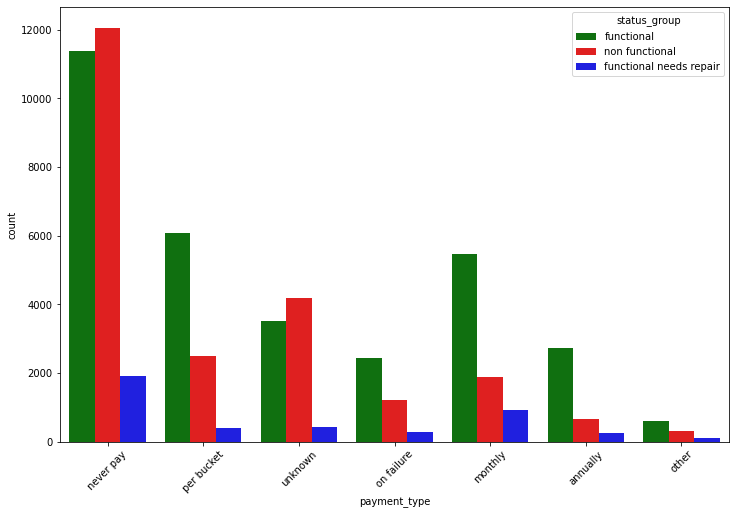

In [ ]:
fig, ax=plt.subplots(figsize=(12,8))
sns.countplot(x='payment_type', hue='status_group', data=df, ax=ax, palette=color_status)
plt.xticks(rotation=45)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<function matplotlib.pyplot.legend>

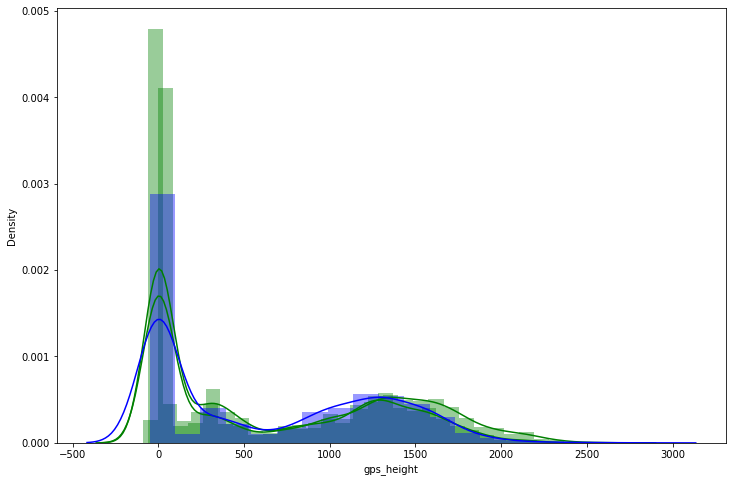

In [ ]:
row_functional=(df['status_group']=='functional')
row_non_functional=(df['status_group']=='non functional')
row_repair=(df['status_group']=='functional needs repair')
col='gps_height'
fig,ax=plt.subplots(figsize=(12,8))
sns.distplot(df[col][row_functional],color='green', label='functional',ax=ax)
sns.distplot(df[col][row_non_functional], color='green', label='non functional',ax=ax)
sns.distplot(df[col][row_repair], color='blue', label='functional needs repair', ax=ax)
plt.legend
